# Important! 
When initially opening the notebook there should be a text to the right of the "Help" menu saying "Changes will not be saved". 
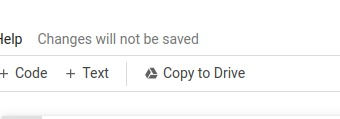

To ensure you can make changes to the notebook save a copy of it to your own drive and work on that one. You can do that by going to "File" -> "Save a copy in Drive".

**Failing to do so will result in code loss!**

 **Note** Make sure you are the only one that has access to it!


In [1]:
#@markdown #Image Processing - 67829. { display-mode: "form" }
#@markdown ##Exercise 5:  Deep Style Image Prior
#@markdown ##Due date: 26.01.2023 at 23:59
#@title{ display-mode: "form" }

#@markdown
#@markdown This exercise is a bit different than the rest of the exercises in the course.
#@markdown The submissions will be a PDF file with your answers and results to the exercise 
#@markdown as well as some files so that we can verify the authenticity of your results.
#@markdown This notebook provides the basic code, but you do not need to adhere to some specific API 
#@markdown and we will not be running unit tests on your code. 
#@markdown We will however, be going over your code and running it manually. 
#@markdown Moreover, we will be running tests to ensure the authenticity of your solution and detect plagiarism
#@markdown
#@markdown
#@markdown Before you start working on the exercise it is recommended that you review the lecture slides covering neural networks,
#@markdown
#@markdown 
#@markdown **NOTE**: Neural networks are typically trained on GPUs, without GPUs training takes much longer. 
#@markdown To enable GPU tranining click on "Runtime" -> "Change runtime type" -> "GPU" -> "SAVE".
#@markdown
#@markdown **NOTE**: A short guide on debugging your code using colab is availble [here](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.06-Errors-and-Debugging.ipynb#scrollTo=qnIn-rWFqoww).

#@markdown But first, we have to download all of the dependencies and install them.
#@markdown Play this cell to download it and get everything ready. markdown This may take a few minutes.

 
!mkdir impr_ex5_resources
%cd impr_ex5_resources
#!wget "https://www.cs.huji.ac.il/~impr/shape_predictor_68_face_landmarks.dat" -O shape_predictor_68_face_landmarks.dat 
#!wget "https://www.cs.huji.ac.il/~impr/align_faces.py" -O align_faces.py 
!wget "https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar" -O stylegan2-ada-pytorch.tar
!tar -xvf stylegan2-ada-pytorch.tar
!rm -f stylegan2-ada-pytorch.tar

import sys
ROOT_PATH="/content/impr_ex5_resources/stylegan2-ada-pytorch"
sys.path.append(ROOT_PATH)

# !pip install --upgrade pillow
!pip install ninja
!pip install mediapy
CHECKPOINTS_PATH = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/ffhq.pkl"

# from PIL import Image

from torchvision import transforms 
import copy
import os
from time import perf_counter
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F

import dnnlib
import legacy
import numpy as np
from skimage.draw import line
from torch.nn.functional import conv2d,conv1d
import mediapy as media
from IPython.display import clear_output

#added
import matplotlib.pyplot as plt
import pdb
import skimage.color


/content/impr_ex5_resources
--2023-01-20 14:27:01--  https://www.cs.huji.ac.il/~impr/stylegan2-ada-pytorch.tar
Resolving www.cs.huji.ac.il (www.cs.huji.ac.il)... 132.65.118.16
Connecting to www.cs.huji.ac.il (www.cs.huji.ac.il)|132.65.118.16|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar [following]
--2023-01-20 14:27:02--  https://www.cs.huji.ac.il/w~impr/stylegan2-ada-pytorch.tar
Reusing existing connection to www.cs.huji.ac.il:443.
HTTP request sent, awaiting response... 200 OK
Length: 100364800 (96M) [application/x-tar]
Saving to: ‘stylegan2-ada-pytorch.tar’

stylegan2-ada-pytor 100%[===================>]  95.71M  9.30MB/s    in 11s     

2023-01-20 14:27:14 (8.41 MB/s) - ‘stylegan2-ada-pytorch.tar’ saved [100364800/100364800]

stylegan2-ada-pytorch/
stylegan2-ada-pytorch/metrics/
stylegan2-ada-pytorch/._dataset_tool.py
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xat

# Mounting Google Drive

In [2]:
#@markdown **NOTE**: It is strongly advised you save your results to Google 
#@markdown Drive as they will be deleted from Colab once it restarts. 
#@markdown To connect Google Drive run this cell. 
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Below is the root dir of your Google Drive. To choose the destenation of the dir to save and read from, create it in your Google Drive and add the relative path to the "GDRIVE_SAVE_REL_PATH" variable below.

In [21]:
ROOT_GDRIVE_PATH="/content/gdrive/MyDrive/"
GDRIVE_SAVE_REL_PATH = "IMPR_Ex5_SM"
FULL_GDRIVE_SAVE_PATH = ROOT_GDRIVE_PATH + GDRIVE_SAVE_REL_PATH
GDRIVE_OUTPUT_SAVE_REL_PATH = FULL_GDRIVE_SAVE_PATH + "/OUTPUT"
MASK_FULL_PATH = FULL_GDRIVE_SAVE_PATH + '/fei_fei_li_inpainting_mask.png'


# General Variables

In [4]:
GAUSSIAN_BLUR_DEGRADATION= 'GAUSSIAN_BLUR_DEGRADATION'
GRAYSCALE_DEGRADATION = 'GRAYSCALE_DEGRADATION'
INPAINTING_DEGRADATION = 'INPAINTING_DEGRADATION'
NO_DEGRADATION= 'NO_DEGRADATION'


# Image Alignment

In [ ]:
# The align_faces.py script takes in an input image path, an output image path, and a dat file path. The dat file is already downloaded for you, so leave it as it is. 
# It is advised that you save the files to google drive as restarting Colab will erase them.
!python "$ROOT_PATH/align_faces/align_faces.py" '/content/gdrive/MyDrive/IMPR_Ex5_SM/beforeAlignGirl.jpg' '/content/gdrive/MyDrive/IMPR_Ex5_SM/afterAlignGirl.jpg' "$ROOT_PATH/align_faces/shape_predictor_68_face_landmarks.dat"

Number of faces detected: 1
Detection 0: Left: 1963 Top: 1043 Right: 3343 Bottom: 2423
Part 0: (2047, 1443), Part 1: (2065, 1608) ...




```
# This is formatted as code
```

# Degradation Functions 

In [55]:
# ********************************************************************************************************
# ******************                   NEED TO ADD DEGRADATION FUNCTIONS                ******************
# ********************************************************************************************************
# imported from ex1




############# blur #############

# imported from ex3, changed it to create 2d gaussian filter
def create_2d_gaussian_filter(kernel_size):
    """
    creates filter vector in size of filter_size using convolution with [1,1]
    then apply Gaussian function and compute the outer product of two filters.
    :param kernel_size: the size of the Gaussian filter (kernel_size,kernel_size)
    to be used in constructing the pyramid filter
    :return: 2d gaussian filter
    """
    if kernel_size == 1:
        return np.array([1])
    elif kernel_size == 2:
        return np.array([1, 1])
    filter_vec = np.ones(2)
    one_vec = filter_vec
    for i in range(2, kernel_size):
        filter_vec = np.convolve(one_vec, filter_vec)
    standard_deviation = kernel_size * kernel_size # ^2
    filter_vec = np.exp(-0.5 * np.power(filter_vec,2) / standard_deviation) # Gaussian function, which is used to smooth the filter vector
    gaussFilter = np.outer(filter_vec,filter_vec) 
    gaussFilter = torch.from_numpy(gaussFilter / gaussFilter.sum()).type(torch.cuda.FloatTensor) #transform to torch , and FloatTensor type
    return gaussFilter[np.newaxis,np.newaxis,:,:] # adds batch,chanels dimentions


def blur_with_gaussian(img):
    gaussFilter = create_2d_gaussian_filter(kernel_size = 9)

    blurred_rgb = []
    blurred_img = torch.zeros(img.shape)
    # could be done without for, but i didnt manage to do it
    for i in range(img.shape[1]):
        print(img[:,i,:,:].shape)
        blurred_rgb.append(torch.nn.functional.conv2d(img[:,i,:,:], gaussFilter,stride=1, padding="same"))

    blured_image =  torch.cat(blurred_rgb,axis=0).unsqueeze(0)
    return blured_image


############# grayscale #############
def rgb_to_grayscale(imRGB):
    """
    Transform an RGB image into the YIQ color space
    :param imRGB: height X width X 3 np.float64 matrix in the [0,1] range
    :return: the image in the YIQ space
    """
    grayImg = 0.2989 * imRGB[:,0,:,:] + 0.5870 * imRGB[:,1,:,:] + 0.1140 * imRGB[:,2,:,:] 
    grayImg = grayImg.repeat(1,3,1,1)
    return grayImg


def inpaint_image(image, device):
    mask = PIL.Image.open(MASK_FULL_PATH) # load mask
    transform = transforms.Compose([transforms.PILToTensor()]) #transfer to Tensor      
    mask = transform(mask)[0,:,:].to(device) / 255 # divide to get binary representation
    masked_image = mask * image + (mask - 1) #adds (mask-1) to get black mask on generated images
    return masked_image


Original Image,Original Degraded Image,Generated Image,Generated Degraded Image

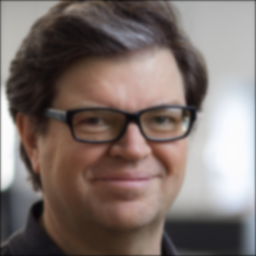
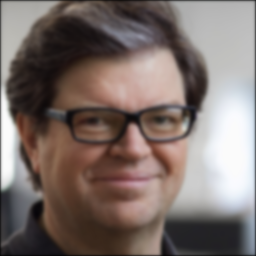
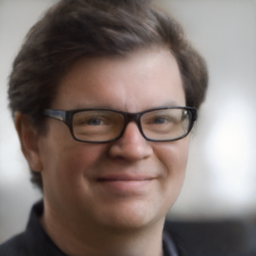
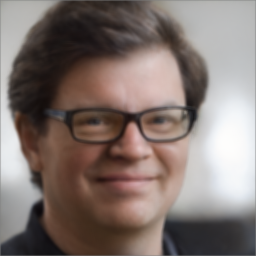

step  981/1000: percep_loss 0.12 latent_dist_reg 0.07 loss 0.19 
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
step  982/1000: percep_loss 0.12 latent_dist_reg 0.07 loss 0.19 
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
step  983/1000: percep_loss 0.12 latent_dist_reg 0.07 loss 0.19 
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
step  984/1000: percep_loss 0.12 latent_dist_reg 0.07 loss 0.19 
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
step  985/1000: percep_loss 0.12 latent_dist_reg 0.07 loss 0.19 
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
step  986/1000: percep_loss 0.12 latent_dist_reg 0.07 loss 0.19 
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
torch.Size([1, 1024, 1024])
step  987/1000: percep_loss 0.12 latent_dist_reg 0.07 loss 0.19 
torch.Size([1, 1024, 1024])
torch.Size([1

In [56]:


def plot_loss( losses , num_steps, latent_dist_reg_weight):
    steps = np.arange(len(losses))

    plt.plot(steps, losses, 'y', label='Loss')
    plt.xlabel("Num steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Optimization progressions with num_steps = " + str(num_steps) + " latent_dist_reg_weight = " + str(latent_dist_reg_weight))
    plt.show() 
    GRAYSCALE_DEGRADATION

# # 3.3.1 - my example for blur using different kernel_size
# invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
#                    target_fname='/content/gdrive/MyDrive/IMPR_Ex5_SM/degraded.png',
#                    outdir=GDRIVE_OUTPUT_SAVE_REL_PATH ,
#                    seed=303,
#                    num_steps=100,
#                    latent_dist_reg_weight=1)


# 3.3.1 - yann_lecun_blur using kernel_size = 10
invert_image(degradation_mode=GAUSSIAN_BLUR_DEGRADATION,
                   target_fname='/content/gdrive/MyDrive/IMPR_Ex5_SM/yann_lecun_blur.png',
                   outdir=GDRIVE_OUTPUT_SAVE_REL_PATH ,
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=1)

 
# # 3.3.1 - alan_turing for blur using different kernel_size
# invert_image(degradation_mode=GRAYSCALE_DEGRADATION,
#                    target_fname='/content/gdrive/MyDrive/IMPR_Ex5_SM/alan_turing_grayscale.png',
#                    outdir=GDRIVE_OUTPUT_SAVE_REL_PATH ,
#                    seed=303,
#                    num_steps=1000,
#                    latent_dist_reg_weight=1)

# 3.3.1 - my example for blur using different kernel_size
# invert_image(degradation_mode=GRAYSCALE_DEGRADATION,
#                    target_fname='/content/gdrive/MyDrive/IMPR_Ex5_SM/grayscale.png',
#                    outdir=GDRIVE_OUTPUT_SAVE_REL_PATH ,
#                    seed=303,
#                    num_steps=1000,
#                    latent_dist_reg_weight=1)

# 3.3.3 - Image Inpainting
# f Fei-Fei Li inpainting
# invert_image(degradation_mode=INPAINTING_DEGRADATION,
#                    target_fname='/content/gdrive/MyDrive/IMPR_Ex5_SM/fei_fei_li_original.png',
#                    outdir=GDRIVE_OUTPUT_SAVE_REL_PATH ,
#                    seed=303,
#                    num_steps=1000,
#                    latent_dist_reg_weight=0.1)


# invert_image(degradation_mode=INPAINTING_DEGRADATION,
#                    target_fname='/content/gdrive/MyDrive/IMPR_Ex5_SM/afterAlignGirl.jpg',
#                    outdir=GDRIVE_OUTPUT_SAVE_REL_PATH ,
#                    seed=303,
#                    num_steps=1000,
#                    latent_dist_reg_weight=0.5)





```
# This is formatted as code
```

# GAN Inversion

In [47]:
def run_latent_optimization(outdir,
    degradation_mode,
    G,
    imgs_to_disply_dict,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    latent_dist_reg_weight     = 0.001,
    device: torch.device
    
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)
    # G  generates new images with same content as the target image but with different styles
    # set G to evaluation mode
    # set gradients to false, this way the parameters are not updated 
    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore
  
    # Compute w stats.
    print(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim) # generate random noise vectors 
    # maps the input tensor to a lower dimension feature space, will be used for generating new images
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [N, L, C], sending to G mapping function the random noise vector
    w_samples = w_samples.cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 18, C]
    w_avg_original = torch.from_numpy(w_avg).to(device).float()
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector ( VGG16 is pre-trained to extract features from images).
    # this features will help to measure the similarity between the generated images and the target image
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device) # also set to evaluation mode
    
    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32) # adds batch dimension 

    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area') # resize image to 256x256
    target_features = vgg16(target_images, resize_images=False, return_lpips=True) # extract features from the target image 

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True)  # creates a tensor from w_avg and set the tensor to keep track of the gradients during the backpropagation
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device) # set with zeros to require gradients
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    
    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    # added code
    losses = np.zeros(num_steps)

    for step in range(num_steps):
        # Learning rate schedule, start with a high value and reduces it over time
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth image from w_opt
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = w_opt + w_noise
        synth_images = G.synthesis(ws, noise_mode='const') # the generated image base on w_opt
        
        # Prep to save synth image
        synth_image_save = (synth_images + 1) * (255/2)
        synth_image_save = synth_image_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    
    
        # ********************************************************************************************************
        # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
        # ********************************************************************************************************
        if  degradation_mode == INPAINTING_DEGRADATION:
            synth_images = inpaint_image(synth_images, device)
        elif degradation_mode == GRAYSCALE_DEGRADATION:
            synth_images =  rgb_to_grayscale(synth_images)
        elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
            synth_images = blur_with_gaussian(synth_images) #applying the degrading function on the generated image

        # ********************************************************************************************************
        # ******************                          END CODE TO ADD SECTION                   ******************
        # ********************************************************************************************************
         
        
        # Prep to save and show images
        synth_image_degraded_save = (synth_images + 1) * (255/2) # saving the generated image after degradation
        synth_image_degraded_save = synth_image_degraded_save.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()  
        
        # save images only in specifcs steps
        if step % 20 == 0:
          imgs_to_disply_dict["Generated Image"]=synth_image_save # saving the generated imaged
          imgs_to_disply_dict["Generated Degraded Image"]=synth_image_degraded_save
          clear_output(wait=True)
          media.show_images(imgs_to_disply_dict,height=256)
        if step % 100 == 0:
          PIL.Image.fromarray(synth_image_save, 'RGB').save(f'{outdir}/intermidiate_%d_not_degraded.png'%step)
          PIL.Image.fromarray(synth_image_degraded_save, 'RGB').save(f'{outdir}/intermidiate_%d_degraded.png'%step)


        # Noise regularization - reduces overfitting, but it can also lead to faster optimization of our model and better overall performance
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        
        # Compute loss
        percep_loss = (target_features - synth_features).square().sum()
        latent_dist_reg = F.l1_loss(w_avg_original, w_opt)
        loss = percep_loss + reg_loss * regularize_noise_weight  + latent_dist_reg_weight * latent_dist_reg

        # added code
        losses[step] = torch.log(loss)


        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        print(f'step {step+1:>4d}/{num_steps}: percep_loss {percep_loss:<4.2f} latent_dist_reg {latent_dist_reg:<4.2f} loss {float(loss):<5.2f}' )

        # Save inverted latent for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()

    # plot_loss( losses , num_steps, latent_dist_reg_weight) #for loss calculation
    return w_out

In [48]:

def invert_image(degradation_mode,
                   target_fname,
                   outdir,
                   seed=303,
                   num_steps=1000,
                   latent_dist_reg_weight=0.001):
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % CHECKPOINTS_PATH)
    device = torch.device('cuda')
    with dnnlib.util.open_url(CHECKPOINTS_PATH) as fp:
        networks = legacy.load_network_pkl(fp)
        G = networks['G_ema'].requires_grad_(False).to(device)
        

    # Load target image.
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    target_pil = PIL.Image.open(target_fname).convert('RGB') #load image and convert to RGB
    w, h = target_pil.size # obtained width and height
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2)) # crop image to square shape
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS) # resize the image to the resolution of G.img_resolution
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    target=torch.tensor([target_uint8.transpose([2, 0, 1])], device=device) #Transposing  because PyTorch assumes the channel dimension is first
    target_images = target[0].unsqueeze(0).to(device).to(torch.float32) # unsqueeze -> adds batch dimension



    # ********************************************************************************************************
    # ******************                   NEED TO FILL IN THE FOLLOWING CODE               ******************
    # ********************************************************************************************************
    if  degradation_mode == INPAINTING_DEGRADATION:
        target_images = inpaint_image(target_images, device)

    elif degradation_mode == GRAYSCALE_DEGRADATION:
        target_images = rgb_to_grayscale(target_images) 

    elif degradation_mode == GAUSSIAN_BLUR_DEGRADATION:
        target_images = blur_with_gaussian(target_images) #applying blur on original image

    # ********************************************************************************************************
    # ******************                          END CODE TO ADD SECTION                   ******************
    # ********************************************************************************************************

    #Save target image
    target_to_save = target_images.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(target_to_save, 'RGB').save(f'{outdir}/original_degraded_image.png')
    imgs_to_disply_dict = {
        "Original Image":target_uint8,
        "Original Degraded Image":target_to_save,
              }
    # Run latent optimization
    start_time = perf_counter()
    optimization_steps = run_latent_optimization(
        outdir,
        degradation_mode,
        G,
        imgs_to_disply_dict,
        target[0],
        num_steps=num_steps,
        device=device,
        latent_dist_reg_weight=latent_dist_reg_weight
    )

    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')
    os.makedirs(outdir, exist_ok=True)

    # Save final inverted image and latent vector.
    inverted_latent = optimization_steps[-1]
    synth_image = G.synthesis(inverted_latent.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    PIL.Image.fromarray(synth_image, 'RGB').save(f'{outdir}/final_inverted_image.png')
    np.savez(f'{outdir}/inverted_latent.npz', latent=inverted_latent.unsqueeze(0).cpu().numpy())